<a href="https://colab.research.google.com/github/Prox-A/LungCancer_Authentication/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

from keras import optimizers
from keras.utils import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

#from keras.applications import ResNet50, DenseNet201, VGG19
#from keras.applications import resnet, densenet

import numpy as np
import matplotlib.pyplot as plt

import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
%matplotlib inline
import time as Time #For measuring how long the training takes
import matplotlib.pyplot as plt # plotting library
import PIL
import PIL.Image
import pathlib
import matplotlib.pyplot

##Importing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/Project_V2/Chest_data')

##تقسيم ومعالجة


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 460

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training", seed = 23,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE
)

test_val_ds = ImageDataGenerator(dtype='float32', rescale= 1./255.)
test_val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation", seed = 123,
    label_mode = 'categorical',
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,

)

Found 900 files belonging to 4 classes.
Using 720 files for training.
Found 900 files belonging to 4 classes.
Using 180 files for validation.


In [ ]:
val_ds = test_val_ds.shard(num_shards = 2, index = 0)
val_ds = test_val_ds.shard(num_shards = 2, index = 1)

##DNN Model

In [ ]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(460,460,3)),
    tf.keras.layers.Dense(5000, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3000, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2000, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4, activation = 'softmax')

])

dnn_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Project_V2/Saved_DNN_h5/DNN_Weights.h5',monitor='val_loss', verbose = 1,
                            save_best_only=True)
dnn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate= 0.00003, decay= 1e-5), loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()])

dnn_model.summary()

In [ ]:
history_model = dnn_model.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks = [checkpointer, early_stopping])

##CNN Model

In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (460,460,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer = 'l2'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

cnn_model.summary()

In [ ]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Project_V2/Saved_CNN_h5/CNN_Weights.h5',monitor='val_loss', verbose = 1,
                            save_best_only=True)
cnn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate= 0.00003, decay= 1e-5), loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()])

cnn_model.summary()

In [ ]:
history_model = cnn_model.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks = [checkpointer, early_stopping])

##Transfer Learning

In [ ]:
original_model = tf.keras.applications.ResNet50V2(include_top = False, input_shape = (460, 460, 3))
original_model.trainable = False

regularizer = tf.keras.regularizers.l2()

for layer in original_model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
print(len(original_model.layers)) # number of layers
print(original_model.layers[0]) # len first layer
print(original_model.layers[0].name) # first layer
print(original_model.layers[1].name) # second layer
print(original_model.layers[len(original_model.layers)-2].name) # second to last model
print(original_model.layers[len(original_model.layers)-1].name) # last layer
original_model.summary()

190
input_1
conv1_pad
post_bn
post_relu
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 460, 460, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 466, 466, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 230, 230, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                 

In [ ]:
resnet_model = Sequential()
resnet_model.add(original_model)
resnet_model.add(Dropout(0.4))
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(4, activation='softmax'))

In [ ]:
#new_model = tf.keras.Model(inputs=model_inputs, outputs=model_outputs)

early_stopping = EarlyStopping(monitor= 'val_loss', patience= 20)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/Project_V2/Saved_TL_H5/Weights_TL.h5',monitor='val_loss', verbose = 1,
                            save_best_only=True)
resnet_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate= 0.00003, decay= 1e-5), loss=tf.keras.losses.CategoricalCrossentropy(),metrics=[tf.keras.metrics.CategoricalAccuracy()])

resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 15, 15, 2048)      23564800  
                                                                 
 dropout (Dropout)           (None, 15, 15, 2048)      0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 batch_normalization (BatchN  (None, 460800)           1843200   
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 4)                 1843204   
                                                        

In [ ]:
history_model = resnet_model.fit(train_ds, epochs = 50, validation_data = val_ds, callbacks = [checkpointer, early_stopping])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.0858 - categorical_accuracy: 0.5292
Epoch 1: val_loss improved from inf to 3.27087, saving model to /content/drive/MyDrive/Project_V2/Saved_TL_H5/Weights_TL.h5
23/23 [==============================] - 66s 2s/step - loss: 1.0858 - categorical_accuracy: 0.5292 - val_loss: 3.2709 - val_categorical_accuracy: 0.3571
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 0.6049 - categorical_accuracy: 0.7833
Epoch 2: val_loss improved from 3.27087 to 1.22080, saving model to /content/drive/MyDrive/Project_V2/Saved_TL_H5/Weights_TL.h5
23/23 [==============================] - 14s 539ms/step - loss: 0.6049 - categorical_accuracy: 0.7833 - val_loss: 1.2208 - val_categorical_accuracy: 0.5833
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.4006 - categorical_accuracy: 0.8542
Epoch 3: val_loss improved from 1.22080 to 0.50163, saving model to /content/drive/MyDrive/Project_V2/Saved_TL_H5/Weights

In [ ]:
resnet_model.save('/content/drive/MyDrive/Project_V2/Saved_TL_H5/Model_TL.h5')

##Load the saved model/weights


Only activate one of these following code lines

In [ ]:
#Saved Model

from keras.models import load_model
saved_model = load_model('/content/drive/MyDrive/Project_V2/Saved_TL_H5/Model_TL.h5')

In [ ]:
#Saved Weights from the best epoch

from keras.models import load_model
saved_model = load_model('/content/drive/MyDrive/Project_V2/Saved_TL_H5/Weights_TL.h5')

##User Prediction

In [ ]:
picnum=1

imgs=[]
imgs_s=[]
for i in range(picnum):
    path_pic = "/content/drive/MyDrive/Project_V2/Predict_Stuff/NormalChestCt.jpg"
    imgs.append(load_img(path_pic))
    imgs_s.append(load_img(path_pic, target_size=(460, 460)))

data1 = []
for i in range(picnum):
  data=np.array(imgs_s[i].getdata())
  data1.append(data)

X = np.array(data1).reshape(1,460,460,3)
Y = np.array([1])

real_pred1 = saved_model.predict(X, batch_size=10)
real_pred = np.where(real_pred1>0.5,1,0).reshape(4)

1/1 [==============================] - 10s 10s/step


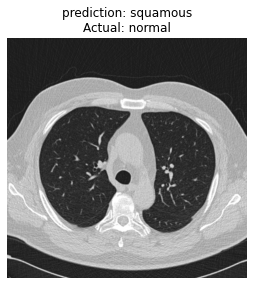

In [ ]:
nrows = 3
ncols = 4
class_names=['squamous','normal','large','adeno']

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

for i in range(picnum):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    plt.imshow(imgs[i])
    plt.title("prediction: "+ class_names[real_pred[i]] +"\nActual: " + class_names[Y[i]])

plt.show()

##Analysis

In [ ]:
history_model.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

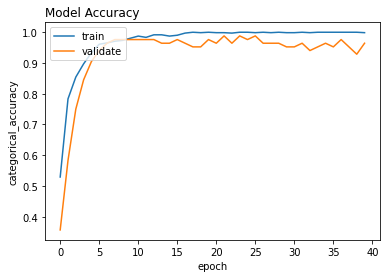

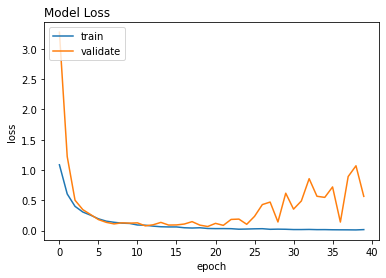

In [ ]:
# graph accuracy
plt.plot(history_model.history['categorical_accuracy'])
plt.plot(history_model.history['val_categorical_accuracy'])
plt.title('Model Accuracy', loc='left')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

#graph loss
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss', loc='left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [ ]:
train_score = resnet_model.evaluate(train_ds, verbose= 1)
valid_score = resnet_model.evaluate(val_ds, verbose= 1)
test_score = resnet_model.evaluate(test_val_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

6/6 [==============================] - 4s 349ms/step - loss: 0.5598 - categorical_accuracy: 0.9611
Train Loss:  0.003748911200091243
Train Accuracy:  1.0
--------------------
Validation Loss:  0.15130503475666046
Validation Accuracy:  0.976190447807312
--------------------
Test Loss:  0.5598182678222656
Test Accuracy:  0.9611111283302307


##Prediction and Analysis

6/6 [==============================] - 7s 387ms/step


[Text(0, 0.5, 'adenocarcinoma'),
 Text(0, 1.5, 'large-cell-carcinoma'),
 Text(0, 2.5, 'normal'),
 Text(0, 3.5, 'squamous-cell-carcinoma')]

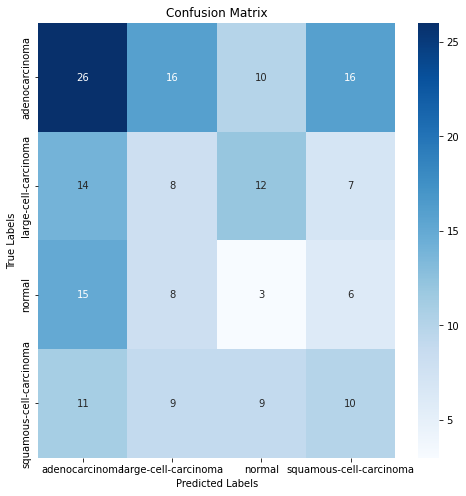

In [ ]:
from sklearn.metrics import confusion_matrix

# make predictions using saved model
y_pred = saved_model.predict(test_val_ds)
y_pred = np.argmax(y_pred, axis=1)

# get true labels from test_val_ds
y_true = []
for x, y in test_val_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))

# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
class_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# set labels, title, and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

In [ ]:
from sklearn.metrics import classification_report

y_pred = saved_model.predict(test_val_ds, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_bool))

6/6 [==============================] - 3s 357ms/step
              precision    recall  f1-score   support

           0       0.33      0.32      0.33        68
           1       0.20      0.20      0.20        41
           2       0.24      0.25      0.24        32
           3       0.21      0.21      0.21        39

    accuracy                           0.26       180
   macro avg       0.24      0.24      0.24       180
weighted avg       0.26      0.26      0.26       180



##Anvil

In [ ]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45227 sha256=3edb4303953c9e774ae38959bb1cb577e8ff986665b2a4e9efa12b72045302a0
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [ ]:
import anvil.server
anvil.server.connect('server_TLOVQXNG3BMRRYGLPNVZRLMJ-NKQRPB7BMSQC5JXP')

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
import anvil
import anvil.media
import PIL
@anvil.server.callable
def classifying_image(file):
  class_names = ['large-cell-carcinoma', 'adenocarcinoma', 'squamous-cell-carcinoma', 'normal']
  with anvil.media.TempFile(file) as filename:
    img = load_img(filename)

  img = img.resize((460,460), resample = PIL.Image.BICUBIC)
  arr = img_to_array(img)
  arr = np.expand_dims(arr, axis = 0)
  arr /= 255.0

  score = saved_model.predict(arr)

  place = np.argmax(saved_model.predict(arr))

  return (class_names[place], score)